In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from keras import optimizers
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras import regularizers
import matplotlib.pyplot as plt

def load_X(X_path):
    file = open(X_path, 'r')
    X_ = np.array(
        [elem for elem in [
            row.split(',') for row in file
        ]], 
        dtype=np.float32
    )
    file.close()
    return X_

def load_Y(y_path):
    file = open(y_path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    return y_

In [3]:
def euclidean_dist(a, b):
    # This function calculates the euclidean distance between 2 point in 2-D coordinates
    # if one of two points is (0,0), dist = 0
    # a, b: input array with dimension: m, 2
    # m: number of samples
    # 2: x and y coordinate
    try:
        if (a.shape[1] == 2 and a.shape == b.shape):
            # check if element of a and b is (0,0)
            bol_a = (a[:,0] != 0).astype(int)
            bol_b = (b[:,0] != 0).astype(int)
            dist = np.linalg.norm(a-b, axis=1)
            return((dist*bol_a*bol_b).reshape(a.shape[0],1))
    except:
        print("[Error]: Check dimension of input vector")
        return 0

In [4]:
def norm_X(X):
    num_sample = X.shape[0]
    # Keypoints
    Nose = X[:,0*2:0*2+2]
    Neck = X[:,1*2:1*2+2]
    RShoulder = X[:,2*2:2*2+2]
    RElbow = X[:,3*2:3*2+2]
    RWrist = X[:,4*2:4*2+2]
    LShoulder = X[:,5*2:5*2+2]
    LElbow = X[:,6*2:6*2+2]
    LWrist = X[:,7*2:7*2+2]
    RHip = X[:,8*2:8*2+2]
    RKnee = X[:,9*2:9*2+2]
    RAnkle = X[:,10*2:10*2+2]
    LHip = X[:,11*2:11*2+2]
    LKnee = X[:,12*2:12*2+2]
    LAnkle = X[:,13*2:13*2+2]
    REye = X[:,14*2:14*2+2]
    LEye = X[:,15*2:15*2+2]
    REar = X[:,16*2:16*2+2]
    LEar = X[:,17*2:17*2+2]

    # Length of head
    length_Neck_LEar = euclidean_dist(Neck, LEar)
    length_Neck_REar = euclidean_dist(Neck, REar)
    length_Neck_LEye = euclidean_dist(Neck, LEye)
    length_Neck_REye = euclidean_dist(Neck, REye)
    length_Nose_LEar = euclidean_dist(Nose, LEar)
    length_Nose_REar = euclidean_dist(Nose, REar)
    length_Nose_LEye = euclidean_dist(Nose, LEye)
    length_Nose_REye = euclidean_dist(Nose, REye)
    length_head      = np.maximum.reduce([length_Neck_LEar, length_Neck_REar, length_Neck_LEye, length_Neck_REye, \
                                 length_Nose_LEar, length_Nose_REar, length_Nose_LEye, length_Nose_REye])
    #length_head      = np.sqrt(np.square((LEye[:,0:1]+REye[:,0:1])/2 - Neck[:,0:1]) + np.square((LEye[:,1:2]+REye[:,1:2])/2 - Neck[:,1:2]))

    # Length of torso
    length_Neck_LHip = euclidean_dist(Neck, LHip)
    length_Neck_RHip = euclidean_dist(Neck, RHip)
    length_torso     = np.maximum(length_Neck_LHip, length_Neck_RHip)
    #length_torso     = np.sqrt(np.square(Neck[:,0:1]-(LHip[:,0:1]+RHip[:,0:1])/2) + np.square(Neck[:,1:2]-(LHip[:,1:2]+RHip[:,1:2])/2))

    # Length of right leg
    length_leg_right = euclidean_dist(RHip, RKnee) + euclidean_dist(RKnee, RAnkle)
    #length_leg_right = np.sqrt(np.square(RHip[:,0:1]-RKnee[:,0:1]) + np.square(RHip[:,1:2]-RKnee[:,1:2])) \
    #+ np.sqrt(np.square(RKnee[:,0:1]-RAnkle[:,0:1]) + np.square(RKnee[:,1:2]-RAnkle[:,1:2]))

    # Length of left leg
    length_leg_left = euclidean_dist(LHip, LKnee) + euclidean_dist(LKnee, LAnkle)
    #length_leg_left = np.sqrt(np.square(LHip[:,0:1]-LKnee[:,0:1]) + np.square(LHip[:,1:2]-LKnee[:,1:2])) \
    #+ np.sqrt(np.square(LKnee[:,0:1]-LAnkle[:,0:1]) + np.square(LKnee[:,1:2]-LAnkle[:,1:2]))

    # Length of leg
    length_leg = np.maximum(length_leg_right, length_leg_left)

    # Length of body
    length_body = length_head + length_torso + length_leg
    
    # Check all samples have length_body of 0
    length_chk = (length_body > 0).astype(int)
    
    # Check keypoints at origin
    keypoints_chk = (X > 0).astype(int)
    
    chk = length_chk * keypoints_chk
    
    # Set all length_body of 0 to 1 (to avoid division by 0)
    length_body[length_body == 0] = 1
    
    # The center of gravity
    # number of point OpenPose locates:
    num_pts = (X[:, 0::2] > 0).sum(1).reshape(num_sample,1)
    centr_x = X[:, 0::2].sum(1).reshape(num_sample,1) / num_pts
    centr_y = X[:, 1::2].sum(1).reshape(num_sample,1) / num_pts

    # The  coordinates  are  normalized relative to the length of the body and the center of gravity
    X_norm_x = (X[:, 0::2] - centr_x) / length_body
    X_norm_y = (X[:, 1::2] - centr_y) / length_body
    
    # Stack 1st element x and y together
    X_norm = np.column_stack((X_norm_x[:,:1], X_norm_y[:,:1]))
        
    for i in range(1, X.shape[1]//2):
        X_norm = np.column_stack((X_norm, X_norm_x[:,i:i+1], X_norm_y[:,i:i+1]))
    
    # Set all samples have length_body of 0 to origin (0, 0)
    X_norm = X_norm * chk
    
    return X_norm

In [5]:
def plot_line(a, b):
    if (a.any()> 0 and b.any()>0): plt.plot([a[0], b[0]], [a[1], b[1]], 'k-')
        
def plot_skeleton(sample, pattern):
    for i in range(len(sample)//2):
        plt.plot(sample[i*2], sample[i*2+1], pattern) 
    skeleton = sample.reshape(1, 36)
    Nose = skeleton[:,0*2:0*2+2][0]
    Neck = skeleton[:,1*2:1*2+2][0]
    RShoulder = skeleton[:,2*2:2*2+2][0]
    RElbow = skeleton[:,3*2:3*2+2][0]
    RWrist = skeleton[:,4*2:4*2+2][0]
    LShoulder = skeleton[:,5*2:5*2+2][0]
    LElbow = skeleton[:,6*2:6*2+2][0]
    LWrist = skeleton[:,7*2:7*2+2][0]
    RHip = skeleton[:,8*2:8*2+2][0]
    RKnee = skeleton[:,9*2:9*2+2][0]
    RAnkle = skeleton[:,10*2:10*2+2][0]
    LHip = skeleton[:,11*2:11*2+2][0]
    LKnee = skeleton[:,12*2:12*2+2][0]
    LAnkle = skeleton[:,13*2:13*2+2][0]
    REye = skeleton[:,14*2:14*2+2][0]
    LEye = skeleton[:,15*2:15*2+2][0]
    REar = skeleton[:,16*2:16*2+2][0]
    LEar = skeleton[:,17*2:17*2+2][0]
    #Nose = sample.reshape(1, 36)[:,0*2:0*2+2][0]
    #Neck = sample.reshape(1, 36)[:,1*2:1*2+2][0]
    plot_line(LEar, LEye)
    plot_line(LEye, Nose)
    plot_line(REar, REye)
    plot_line(REye, Nose)
    plot_line(Nose, Neck)
    plot_line(Neck, LShoulder)
    plot_line(LShoulder, LElbow)
    plot_line(LElbow, LWrist)
    plot_line(Neck, RShoulder)
    plot_line(RShoulder, RElbow)
    plot_line(RElbow, RWrist)
    plot_line(Neck, LHip)
    plot_line(LHip, LKnee)
    plot_line(LKnee, LAnkle)
    plot_line(Neck, RHip)
    plot_line(RHip, RKnee)
    plot_line(RKnee, RAnkle)
    
def plot(sample):
    # sample is one-dimension array
    # e.g: (36,)
    if sample.shape[0] == 36:
        sample_norm = norm_X(sample.reshape(1,36))[0]

        # Plot original coordinates
        pad_ori = 40
        plt.figure(str(sample))
        plt.subplot(121)
        plt.title('Original skeleton')
        X_ori = sample
        x_max = max(X_ori[0::2]) + pad_ori
        x_min = min(i for i in X_ori[0::2] if i > 0) - pad_ori
        y_max = max(X_ori[1::2]) + pad_ori
        y_min = min(j for j in X_ori[1::2] if j > 0) - pad_ori
        plt.xlim(x_min,x_max)
        plt.ylim(y_max, y_min)
        plot_skeleton(X_ori, 'bo')

        # Plot normalized coordinates
        pad_nor = 0.2
        #plt.figure(2)
        plt.subplot(122)
        plt.title('Normalized skeleton')
        X_nor = sample_norm
        x_max = max(X_nor[0::2]) + pad_nor
        x_min = min(X_nor[0::2]) - pad_nor
        y_max = max(X_nor[1::2]) + pad_nor
        y_min = min(X_nor[1::2]) - pad_nor
        plt.xlim(x_min,x_max)
        plt.ylim(y_max, y_min)
        plot_skeleton(X_nor, 'ro')
    else:
        print("sample is one-dimension array: (36,)")

In [15]:
# Create a model
model = keras.Sequential([
    keras.layers.Dense(64, activation='sigmoid', input_shape=(36,)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation='sigmoid'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(16, activation='sigmoid'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax')
])
model.summary()

# plot training log
def plot_history(history):
    history_dict = history.history
    history_dict.keys()
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # "bo" is for "blue dot"
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'ro', label='Validation loss')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation loss/acc')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                2368      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_7 (Dense)             (None, 3)                

In [7]:
model.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0.01), metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [8]:
# Load and norminalize dataset
X_train = load_X('dataset/X_train.txt')
Y_train = load_Y('dataset/Y_train.txt')
X_train_norm = norm_X(X_train)

X_test = load_X('dataset/X_test.txt')
Y_test = load_Y('dataset/Y_test.txt')
X_test_norm = norm_X(X_test)

In [9]:
history = model.fit(X_train_norm, Y_train, validation_data=(X_test_norm, Y_test), epochs=500, batch_size=32, verbose=1)#, callbacks= [earlyStopping])

Epoch 1/500
84/84 [==============================] - 3s 7ms/step - loss: 1.0915 - accuracy: 0.3935 - val_loss: 0.9231 - val_accuracy: 0.6277
Epoch 2/500
84/84 [==============================] - 0s 5ms/step - loss: 0.8700 - accuracy: 0.5538 - val_loss: 0.6904 - val_accuracy: 0.7090
Epoch 3/500
84/84 [==============================] - 0s 4ms/step - loss: 0.7067 - accuracy: 0.6842 - val_loss: 0.5413 - val_accuracy: 0.7732
Epoch 4/500
84/84 [==============================] - 0s 5ms/step - loss: 0.6090 - accuracy: 0.7556 - val_loss: 0.4749 - val_accuracy: 0.8003
Epoch 5/500
84/84 [==============================] - 0s 5ms/step - loss: 0.5687 - accuracy: 0.7945 - val_loss: 0.4504 - val_accuracy: 0.8088
Epoch 6/500
84/84 [==============================] - 0s 5ms/step - loss: 0.5134 - accuracy: 0.8161 - val_loss: 0.3647 - val_accuracy: 0.8474
Epoch 7/500
84/84 [==============================] - 0s 5ms/step - loss: 0.4648 - accuracy: 0.8371 - val_loss: 0.3425 - val_accuracy: 0.8830
Epoch 8/500
8

In [14]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

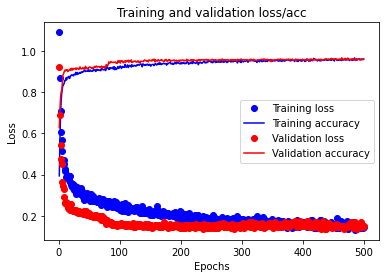

In [16]:
plot_history(history)

In [ ]:
# save model 
model.save('pose_classifier.h5')

Estimated pose:
STANDING: 	0.013973521
BENDING: 	0.034460872
CROUCHING: 	0.95156556


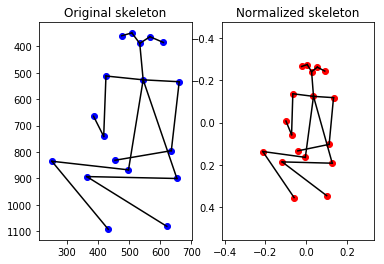

In [ ]:
# Testing on single example
LABELS = ["STANDING", "BENDING", "CROUCHING"]

X_sample = load_X('dataset/X_sample.txt')
X_sample_norm = norm_X(X_sample)
y_out = model.predict(X_sample_norm[0].reshape(1, 36))

print("Estimated pose:")
for idx in range(len(LABELS)):
    print(LABELS[idx] + ": \t" + str(y_out[0][idx]))
plot(X_sample[0])
